# Grayscale to RGB - Código Demonstrativo 

Este notebook é um código demonstrativo do projeto Grayscale to RGB, realizado para a disciplina de Processamento de Imagens da Universidade de São Paulo.

Ao decorrer deste notebook, carregamos um modelo treinado anteriormente, e o utilizamos para transformar imagens em escalas de cinza para imagens coloridas. Para facilitar a comparação visual da imagem gerada, para a imagem colorida correta, este notebook espera como entrada imagens RGB ao invés de imagens em escalas de cinza, e ao decorrer do documento, convertemos esta imagem de entrada para escalas de cinza.

## Arquivos Necessários para Execução

Para a execução correta deste notebook, necessita-se de dois arquivos, o primeiro sendo a imagem colorida de entrada, e o segundo e o arquivo que armazena a rede treinada, este arquivo têm como nome "model_state" pode ser encontrado neste link: https://github.com/RodrigoArboleda/Grayscale-to-RGB.

Os nomes destes arquivos devem ser devidamente especificados ao decorrer do notebook, as células onde se insere estes valores estão em negrito.

Também é necessário os parametros MEAN e STD da rede treinada, estes, podendo ser encontrados no mesmo repositório.

## Ambiente de Execução

É necessário uma GPU capaz de executar cuda para a execução do notebook, caso não tenha acesso a este recurso, considere utilizar o Google Colab.

## Integrantes do Grupo

Luan Ícaro Pinto Arcanjo - 10799230

Victor Graciano de Souza Correia - 10431201

Rodrigo Cesar Arboleda - 10416722

## Instalando Bibliotecas

Abaixo esta todas as bibliotecas utilizadas ao decorrer de todo o projeto.

In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as dataset_loader
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from skimage.io import imread_collection

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imageio

## $\textbf{INSIRA OS DADOS DE ENTRADA}$

### Insira o nome do arquivo com os pesos da rede treinada e os parametros MEAN e STD.

In [ ]:
#PATH da CNN salvada
PATH = "model_state_2000_epochs"

#parametros do conjunto de teste, para conversao
MEAN = 121.88642883300781
STD = 121.88642883300781

### Insira o nome do arquivo da imagem de entrada.

In [ ]:
img_name = "pirata_que_estica.jpg"

## Funções Implementadas

Abaixo há a criação das funções auxliares utilizadas ao decorrer do notebbok, sendo estas funções:

* image_plot - Faz o plot de imagens
* CNN - código que define a arquitetura de rede.
* transform_to_gray - transforma um conjunto de imagens RGB em escalas de cinza.
* tranform_img_to_gray - transforma uma imagem RGB em escalas de cinza.
* transform_and_create_torch_tensors = envia as imagens para GPU e cria os torch tensors.

In [ ]:
'''
Esta funcao plota um conjunto de imagens passadas por parametro, ela plota 
apenas um numero quadrado de imagens, se for passado uma quantidade não quadrada,
ira plotar apenas uma quantidade de imagens equivalente ao numero quadrado mais
proximo por baixo da quantidade de imagens passada.
@PARAMETROS
  image_vector - o conjutno de imagens a ser plotado
  color - indica se as imagens sao RGB ou em escalas de cinza.
    0 - escalas de cinza
    1 - RGB
'''
def image_plot(image_vector, color):
  size = image_vector.shape[0]
  size = int(size**(1/2))
  f, ax = plt.subplots(size,size)
  for i in range(size):
    for j in range(size):
      if color:
        ax[i,j].imshow(image_vector[i*size+j].astype(np.uint8))
      else:
        ax[i,j].imshow(image_vector[i*size+j,:,:,0].astype(np.uint8), cmap='gray', vmin=0, vmax=255)

In [ ]:
'''
Funcao auxiliar para definir a arquitetura da rede,
esta funcao retorna um pipeline sequencial de seguinte sequencia:
  Camada de convolucao - out_c filtros de tamanho 3x3 com padding 1.
  ReLU
  Camada de convolucao - out_c filtros de tamanho 3x3 com padding 1.
  ReLU
O que iremos definir por conveniencia como convolucao dupla.
@PARAMETROS
  in_C - profundidade de entrada da convolucao dupla.
  out_c - profundidade de saida da convolucao dupla.
'''
def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)

    )

    return conv

'''
Funcao que define a arquitetura da rede neural, como especificado no README do
repositorio https://github.com/RodrigoArboleda/Grayscale-to-RGB
'''
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = double_conv(1,32)
        self.conv2 = double_conv(32,64)
        self.conv3 = double_conv(64,64)
        self.linear1 = nn.Linear(64*8*8, 1024)
        self.linear2 = nn.Linear(1024, 3072)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, image):
        #taking batch_size

        batch_size = image.size()[0]
        # Encoder Phase
        x1 = self.conv1(image)
        x2 = self.max_pool(x1)
        
        x3 = self.conv2(x2)
        x4 = self.max_pool(x3)
        
        x5 = self.conv3(x4)
        # Decoder Phase
        x6 = self.linear1(x5.view(batch_size,-1))
        
        f1 = F.relu(x6)
        f2 = torch.sigmoid(self.linear2(f1)).view(-1, 3, 32, 32)
        return f2

In [ ]:
'''
Esta funcao transforma um conjunto de imagem RGB para grayscale, atraves da 
formula:
  GRAY =  0.299*R  + 0.587*G + 0.114*B
E deixa as imagens em grayscale já preparada para transformar em torch tensors.
@PARAMETROS
  images_RGB - imagens RGB a serrem convertidas.
@RETORNO
  images_GRAY - imagens em escalas de cinza criadas.
'''
def transform_to_gray( images_RGB ):

    R = images_RGB[:, :, :,0]
    G = images_RGB[:, :, :,1]
    B = images_RGB[:, :, :,2]

    images_GRAY =  0.299*R  + 0.587*G + 0.114*B 
    
    return images_GRAY.reshape( images_RGB.shape[0],32,32,1 )

In [ ]:
'''
Esta funcao transforma uma imagem RGB para grayscale, atraves da 
formula:
  GRAY =  0.299*R  + 0.587*G + 0.114*B
E deixa a imagem em grayscale já preparada para transformar em torch tensors.
@PARAMETROS
  images_RGB - imagem RGB a ser convertida.
@RETORNO
  images_GRAY - imagem em escalas de cinza criada.
'''
def transform_img_to_gray( img):
    return transform_to_gray( img.reshape(1,32,32,3)  )

In [ ]:
'''
Esta funcao envia as imagens cria os torch tensors do conjunto de imagens,
atraves das imagens em numpy, e envia os dados para GPU
@PARAMETROS
  data - conjunto de imagens.
  batch_size - tamanho do batch utilizado nos treinos, para este notebook,
      o valor eh a constante = 1.
@RETORNO
  torch tensor - torch tensor das imagens passadas como parametro.
'''
def transform_and_create_torch_tensors(data, batch_size):
    
    data = torch.from_numpy(data).float().cuda()
    return data.contiguous().view(data.size(0),batch_size,-1,32,32)

## Fluxo Principal do Notebook

Abaixo, há o fluxo principal do notebook, fazendo os procedimentos de carregar a rede treinada, e a utilizar para avaliar uma imagem

In [ ]:
'''
Carregando o modelo treinado
'''
model = CNN()
model.cuda()
model.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [ ]:
'''
Esta funcao faz o processo de transformar uma imagem em escalas de cinza, para 
uma imagem RGB< utilizando a rede neural treinada.
@PARAMETROS
  img_gray - imagem em escalas de cinza.
@RETORNO
  img_rgb - imagem RGB criada atraves da rede.
'''
def grayscale_to_RGB(img_gray):
    #colocando a imagem no formato correto
    img_gray = img_gray.reshape(1,32,32,1)
    #utilizando os parametros MEAN e STD para normalizar a imagem.
    img_gray_norm = (img_gray-MEAN)/STD

    #criando o tensor da imagem
    img_gray_tensor = transform_and_create_torch_tensors(img_gray_norm, 1)
    #passando a imagem atraves da rede.
    tmp = model(img_gray_tensor[0])[0].detach().cpu().numpy()*255
    img_rgb = tmp.reshape(32,32,3).astype(np.uint8)

    return img_rgb

In [ ]:
#carregando a imagem atraves de seu nome de arquivo
img = imageio.imread(img_name)

In [ ]:
#transformando a imagem de entrada em escalas de cinza.
img_gray = transform_img_to_gray(img[:,:,0:3])

In [ ]:
#avaliando a imagem em escalas de cinza na rede neural.
img_created = grayscale_to_RGB(img_gray)

### Plotando a imagem

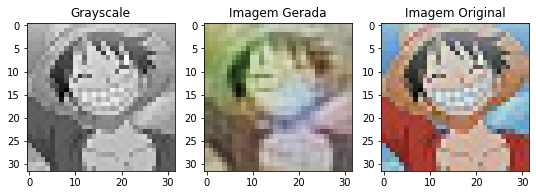

In [ ]:
f, ax = plt.subplots(1,3, figsize=(9, 3))

ax[0].set_title('Grayscale')
ax[0].imshow(img_gray.reshape(32,32), cmap='gray')

ax[1].set_title('Imagem Gerada')
ax[1].imshow(img_created)

ax[2].set_title('Imagem Original')
ax[2].imshow(img)

plt.show()